# Ensemble model for Time Series Forecasting

Ensemble learning is a very promising technique for time series forecasting. The purpose of ensemble learning is to combine several simple models into a single strong learner to reduce errors or improve forecasting results.

StatsForecast allows to create Ensembles models in a very easy way. First we need to import the data that we are going to use (in this case M4 Dataset). After that, we´ll to generate the forecasts via the `generate_forecast()` function. Finally, we´ll create the ensemble models using the forecasts previusly generated. In this notebook we’ll implement and benchmark a ensemble model of AutoARIMA, AutoETS and AutoCES:

+ AutoARIMA: The autoregressive integrated moving average (ARIMA), combines differencing steps, lag regression and moving averages into a single method capable of modeling non-stationary time series. This method complements on ETS and it is based on the description of data’s autocorrelations.

+ ETS: The exponential smoothing (ETS) algorithm is especially suited for data with seasonality and trend. ETS computes a weighted average over all observations in the input time series dataset as its prediction. In contrast to moving average methods with constant weights, ETS weights exponentially decrease over time, capturing long term dependencies while prioritizing new observations.

+ CES algorithm models the time series using “information potential”, modeling the non-linearity in time series using a complex-valued representation. The weights exponentially decrease over time on complex and real plains rather than the constant weights in simple moving average methods.

### Import the libraries that we are going to use for the analysis:

In [176]:
# Data Manipulation
import pandas as pd
import numpy as np
import scipy

# Plotting graphs
import matplotlib.pyplot as plt

# Statsforecast
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.models import ETS
from statsforecast.models import AutoCES
from statsforecast.models import Naive
from neuralforecast.data.datasets.m4 import M4, M4Info

# Others
from itertools import product
import warnings
warnings.filterwarnings('ignore')
from time import time 
import random
import fire
import os

### Loading and Exploring the M4 Dataset

The M4 dataset is a collection of 100,000 time series used for the fourth edition of the Makridakis forecasting Competition. The M4 dataset consists of time series of yearly, quarterly, monthly and other (weekly, daily and hourly) data, which are divided into training and test sets. The minimum numbers of observations in the training test are 13 for yearly, 16 for quarterly, 42 for monthly, 80 for weekly, 93 for daily and 700 for hourly series. The participants were asked to produce the following numbers of forecasts beyond the available data that they had been given: six for yearly, eight for quarterly, 18 for monthly series, 13 for weekly series and 14 and 48 forecasts respectively for the daily and hourly ones.

The M4 dataset was created by selecting a random sample of 100,000 time series from the ForeDeCk database. The selected series were then scaled to prevent negative observations and values lower than 10, thus avoiding possible problems when calculating various error measures. The scaling was performed by simply adding a constant to the series so that their minimum value was equal to 10 (29 occurrences across the whole dataset). In addition, any information that could possibly lead to the identification of the original series was removed so as to ensure the objectivity of the results. This included the starting dates of the series, which did not become available to the participants until the M4 had ended.

In [239]:
# Create a dictionary with the data:
dict_datasets = {'M4': (M4, M4Info)}

# Obtain the series titles
plot_titles = dict(zip(ids, ids))

In [211]:
def generate_forecast(directory: str, dataset, group):

    '''generate_forecast() function: Return a dataframe with AutoARIMA, ETS and CES forecasts for the group required.

    * df_forecast: 'data'
    * dataset: 'M4'
    * group: Refeers to the M4 group (Hourly, Daily, Weekly, Monthly, Quarterly or Yearly)'''

    dataclass, datainfo = dict_datasets[dataset]
    Y_df_group, *_ = dataclass.load(directory, group)
    
    ids = list(Y_df_group['unique_id'].unique())
    Y_df = Y_df_group.query('unique_id in @ids')
    Y_df["unique_id"] = Y_df["unique_id"].astype(str)

    # Set the forecast horizon and frecuency:
    horizon = datainfo[group].horizon
    freq = datainfo[group].freq
    seasonality = datainfo[group].seasonality

    # Split data in train and test series:
    Y_df_test = Y_df.groupby('unique_id').tail(horizon)
    Y_train_df = Y_df.drop(Y_df_test.index)

    # Define the models that are going to compose the ensemble:
    models = [AutoARIMA(season_length=seasonality, approximation=True),
              ETS(season_length=seasonality, model='ZZA'), 
              AutoCES(season_length=seasonality)]

    # Create the forecast object and forecast test set:
    model = StatsForecast(df=Y_train_df, models=models, freq=freq, n_jobs=-1, fallback_model= Naive())
    start = time()
    Y_hat_df = model.forecast(horizon).reset_index()
    end = time()

    Y_test_df = Y_df_test.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])

    return Y_test_df

In [229]:
def get_train_df(group: str):

    '''generate_forecast() function: Return a dataframe with AutoARIMA, ETS and CES forecasts for the group required.

    * group: Refeers to the M4 group (Hourly, Daily, Weekly, Monthly, Quarterly or Yearly)'''

    dataclass, datainfo = dict_datasets['M4']
    Y_df_total, *_ = dataclass.load('data', group)
    seasonality = datainfo[group].seasonality
    Y_train_df = Y_df_total.drop(Y_df_total.groupby('unique_id').tail(seasonality).index)
    
    return Y_train_df

In [230]:
# Plot functions:
def plot_grid(df_train, plot_titles, model_cols=["y_50"], df_test=None, plot_random=True):
    """Plots multiple time series."""
    fig, axes = plt.subplots(4, 2, figsize = (24, 14))

    unique_ids = df_train['unique_id'].unique()

    assert len(unique_ids) >= 8, "Must provide at least 8 ts"
    
    if plot_random:
        unique_ids = random.sample(list(unique_ids), k=8)
    else:
        unique_uids = unique_ids[:8]

    for uid, (idx, idy) in zip(unique_ids, product(range(4), range(2))):
        train_uid = df_train.query('unique_id == @uid')
        axes[idx, idy].plot(train_uid['ds'], train_uid['y'], label = 'y_train', c='black')
        axes[idx, idy].xaxis.set_tick_params(rotation=45)
        if df_test is not None:
            max_ds = train_uid['ds'].max()
            test_uid = df_test.query('unique_id == @uid')
            axes[idx, idy].plot(test_uid['ds'], test_uid['y'], c='black', label='True')

            for col in model_cols:
                axes[idx, idy].plot(test_uid['ds'], test_uid[col], label=col)

        axes[idx, idy].set_title(f'State: {plot_titles[uid]}')
        axes[idx, idy].set_xlabel('Timestamp [t]')
        axes[idx, idy].set_ylabel('Target')
        axes[idx, idy].legend(loc='upper left')
        axes[idx, idy].xaxis.set_major_locator(plt.MaxNLocator(20))
        axes[idx, idy].grid()
    fig.subplots_adjust(hspace=0.7)
    plt.show()

In [166]:
'''accuracy() function: Return a dataframe whith the measures RMSE, MAE, MAPE and MASE of the models evaluated.

* df_forecast: Dataframe with a columns that contain observed values called obs_values and columns that contains forecasts.
* group: Refeers to the M4 group (Hourly, Daily, Weekly, Monthly, Quarterly or Yearly)'''

def accuracy(df_forecast, group):

    dataclass, datainfo = dict_datasets['M4']
    Y_df_total, *_ = dataclass.load('data', group)
    seasonality = datainfo[group].seasonality
    horizon = datainfo[group].horizon
    Y_train_df = Y_df_total.drop(Y_df_total.groupby('unique_id').tail(seasonality).index)
    y_train_serie = Y_train_df.y.values
    method = df_forecast.columns[3:]
    rmse_results = []
    mae_results = []
    mape_results = []
    mase_results = []

    y = df_forecast['y'].values
    y_hat_naive = []
    for i in range(horizon):
        y_hat_naive.append(y[-1])
    scale = np.abs(y_train_serie[:-seasonality] - y_train_serie[seasonality:])
    scale = np.average(scale)

    for i in method:

        y_hat = df_forecast[i].values
        d = y - y_hat
        mae_f = np.mean(abs(d))
        rmse_f = np.sqrt(np.mean(d**2))
        mape = np.mean(np.abs((y - y_hat)/y))*100
        mase = mae_f / scale
        mae_results.append(np.round(mae_f,2))
        rmse_results.append(np.round(rmse_f,2))
        mape_results.append(np.round(mape,2))
        mase_results.append(np.round(mase,2))

    accuracy_df = pd.DataFrame({'Method':method,
                    'RMSE':rmse_results,
                    'MAE':mae_results,
                    'MAPE':mape_results,
                    'MASE':mase_results})

    return accuracy_df

### Hourly time series forecast:

In [80]:
# Create forecasts:
hourly_df_forecast = generate_forecast('data', 'M4', 'Hourly')

In [128]:
# Create Ensemble models:
hourly_df_forecast['Ensemble_mean'] = (hourly_df_forecast.AutoARIMA + hourly_df_forecast.ETS + hourly_df_forecast.CES) / 3
hourly_df_forecast['Ensemble_median'] = hourly_df_forecast.median(axis=1)

# Export Pandas DataFrame to CSV:
hourly_df_forecast.to_csv('hourly_df_forecast.csv')

# Print dataframe:
hourly_df_forecast

,unique_id,ds,y,AutoARIMA,ETS,CES,Ensemble_mean,Ensemble_median
0,H1,701,619.0,616.084167,631.889587,621.200012,623.057922,621.200012
1,H1,702,565.0,544.432129,559.750854,556.268921,553.483948,556.268921
2,H1,703,532.0,510.414490,519.235474,512.232849,513.960938,513.960938
3,H1,704,495.0,481.046539,486.973358,479.324799,482.448242,482.448242
4,H1,705,481.0,460.893066,464.697357,457.910278,461.166901,461.166901
...,...,...,...,...,...,...,...,...
19867,H99,744,24039.0,26955.496094,26916.310547,26628.867188,26833.556641,26833.556641
19868,H99,745,22946.0,25947.765625,26036.806641,25965.550781,25983.375000,25965.550781
19869,H99,746,22217.0,25043.929688,25449.199219,25611.035156,25368.054688,25368.054688
19870,H99,747,21416.0,24461.449219,24974.529297,25202.986328,24879.654297,24879.654297


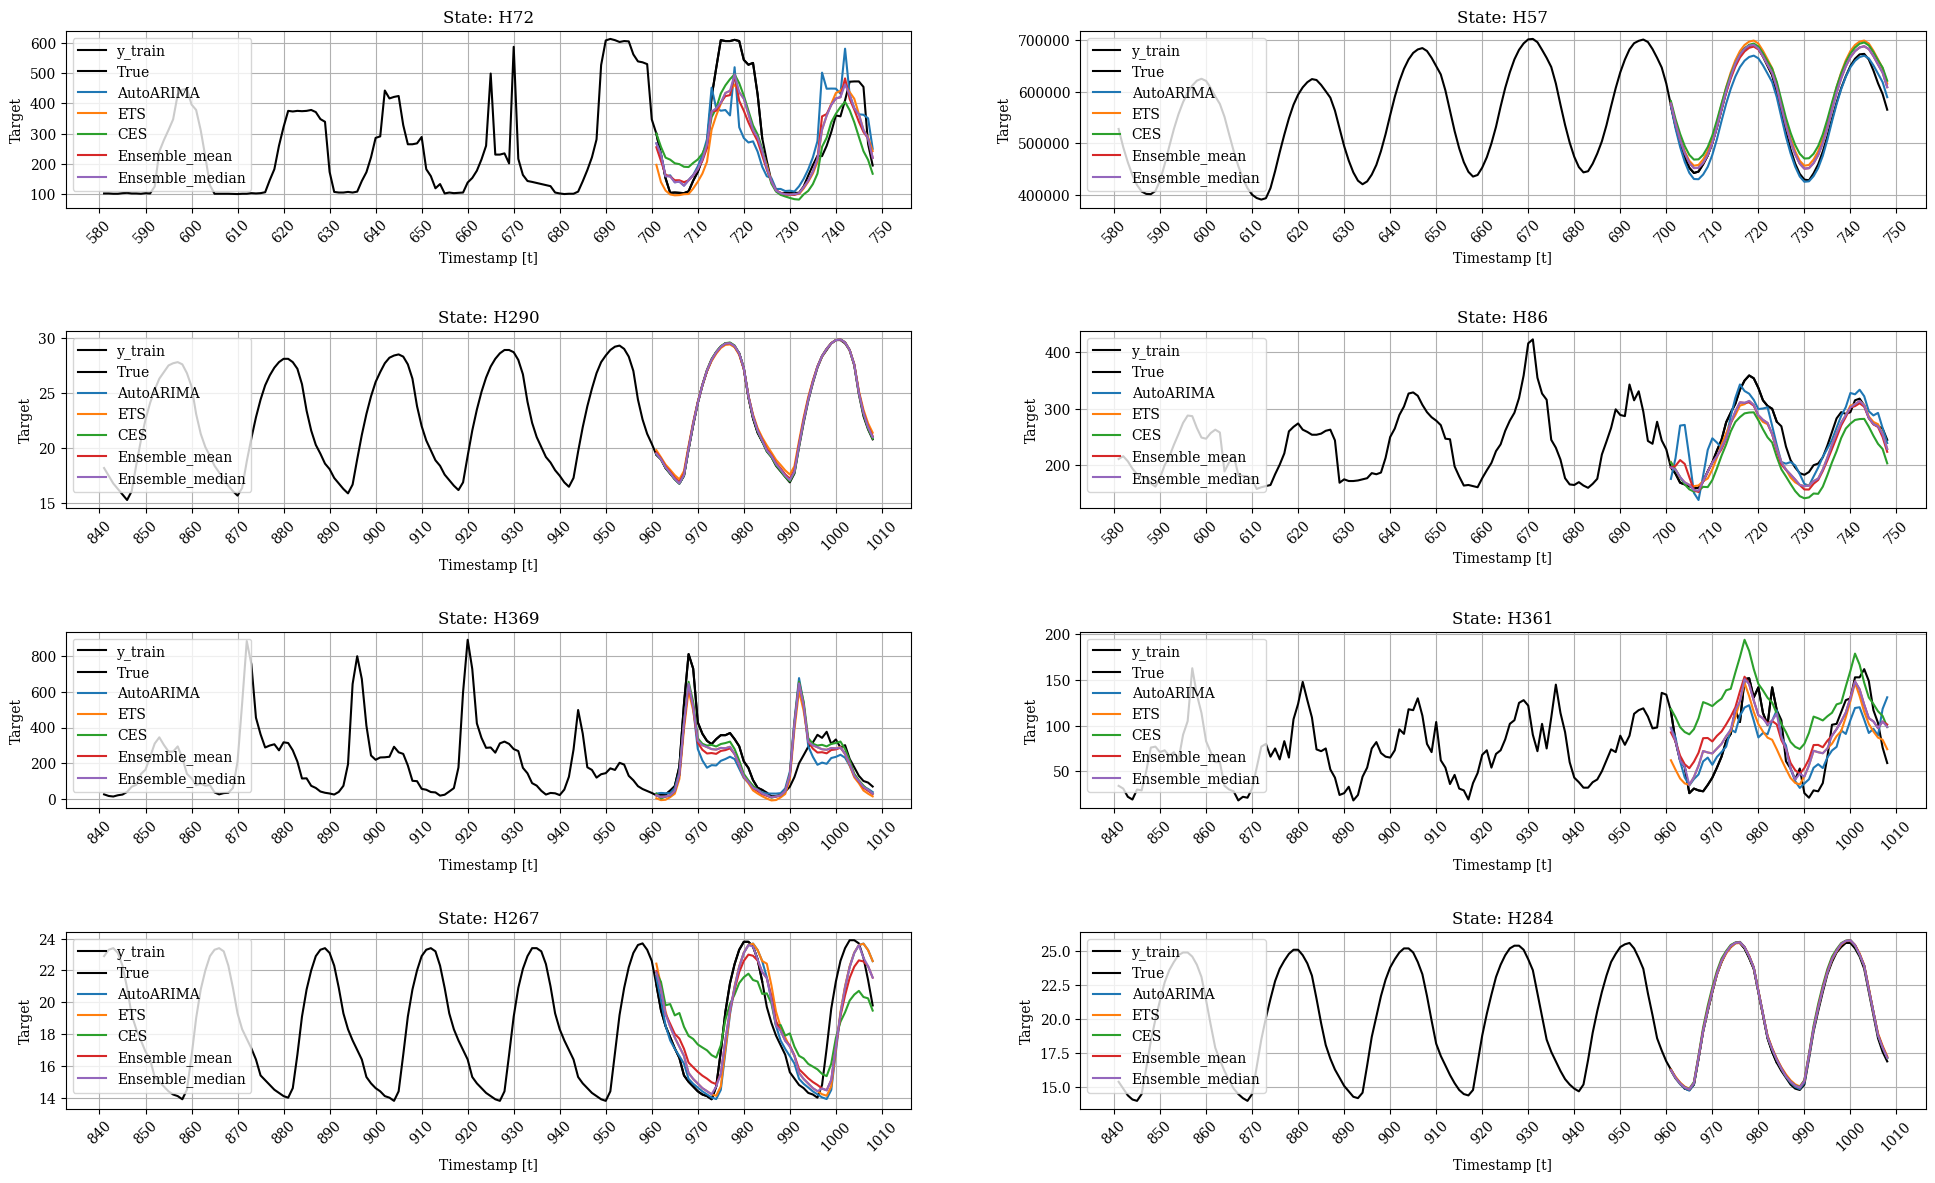

In [231]:
# Get trarin dataframe:
df_train_hourly = get_train_df('Hourly')

# Plot a random sample of 8 series
plot_grid(df_train_hourly.groupby('unique_id').tail(3*horizon), 
          plot_titles=plot_titles, 
          model_cols=['AutoARIMA', 'ETS', 'CES', 'Ensemble_mean', 'Ensemble_median'], 
          df_test=hourly_df_forecast)

In [167]:
# Measures RMSE, MAE, MAPE and MASE of the models evaluated:
accuracy(hourly_df_forecast, 'Hourly')

,Method,RMSE,MAE,MAPE,MASE
0,AutoARIMA,1422.18,271.31,17.28,0.47
1,ETS,1939.82,356.30,19.39,0.61
2,CES,2092.24,378.99,26.91,0.65
3,Ensemble_mean,1582.52,292.23,18.31,0.50
4,Ensemble_median,1561.91,270.59,14.41,0.47


### Daily time series forecast:


In [106]:
# Create forecasts:
daily_df_forecast = generate_forecast('data', 'M4', 'Daily')

In [138]:
# Create Ensemble models:
daily_df_forecast['Ensemble_mean'] = (daily_df_forecast.AutoARIMA + daily_df_forecast.ETS + daily_df_forecast.CES) / 3
daily_df_forecast['Ensemble_median'] = daily_df_forecast.median(axis=1)

# Export Pandas DataFrame to CSV:
daily_df_forecast.to_csv('daily_df_forecast.csv')

# Print dataframe:
daily_df_forecast

,unique_id,ds,y,AutoARIMA,ETS,CES,Ensemble_mean,Ensemble_median
0,D1,1007,2039.20,2029.699951,2030.085449,2031.183716,2030.323120,2030.323120
1,D1,1008,2035.00,2029.699951,2030.490479,2031.404907,2030.531738,2030.531738
2,D1,1009,2051.80,2029.699951,2031.520142,2033.011230,2031.410522,2031.520142
3,D1,1010,2061.80,2029.699951,2031.380371,2034.094849,2031.725098,2031.725098
4,D1,1011,2063.50,2029.699951,2031.599487,2035.724609,2032.341309,2032.341309
...,...,...,...,...,...,...,...,...
59173,D999,1062,1262.08,1245.374634,1241.501099,1245.221924,1244.032593,1245.221924
59174,D999,1063,1262.78,1245.374634,1243.573120,1247.038818,1245.328857,1245.374634
59175,D999,1064,1264.66,1245.374634,1241.336304,1245.280029,1243.996948,1245.280029
59176,D999,1065,1272.66,1245.374634,1244.501709,1248.611938,1246.162720,1246.162720


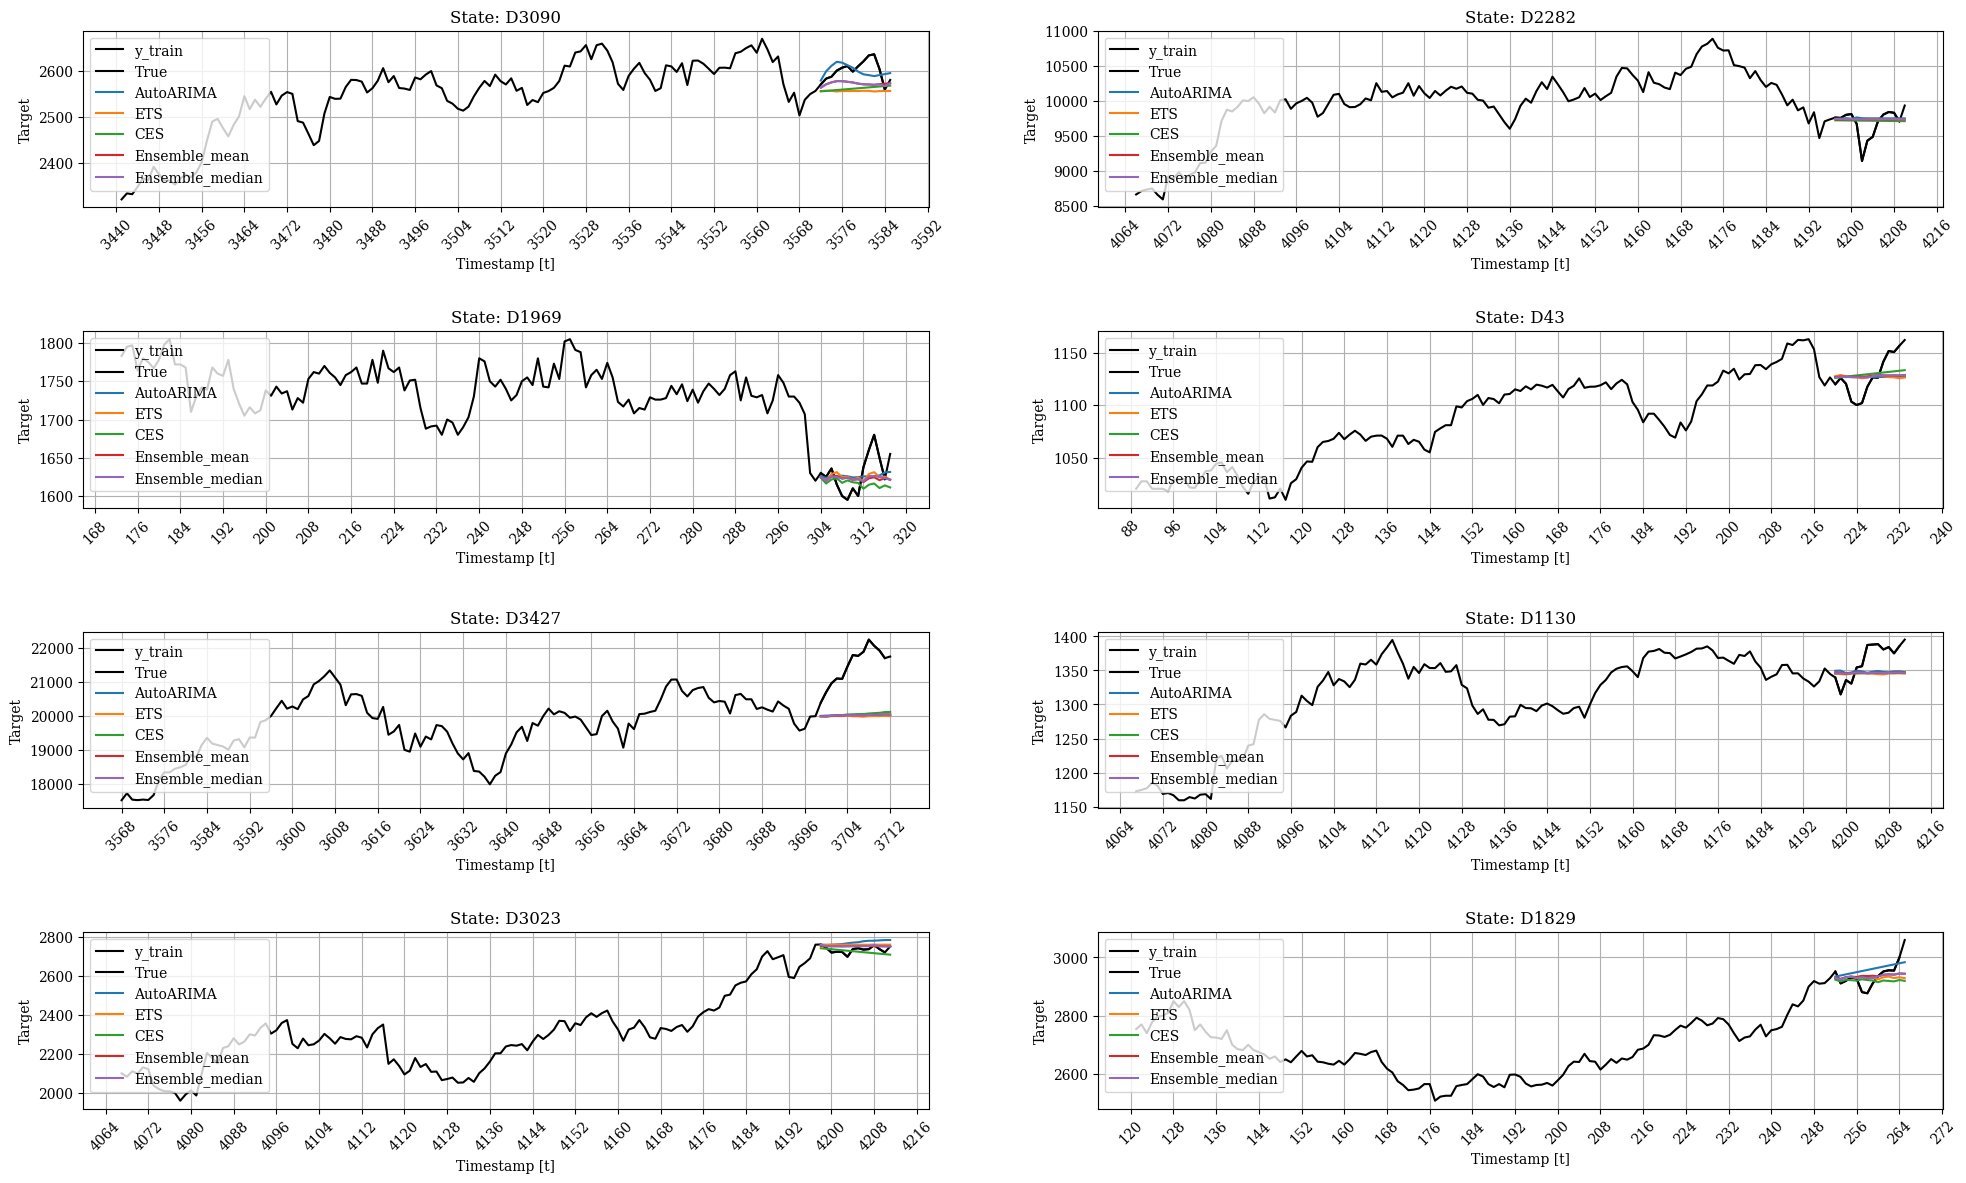

In [236]:
# Get trarin dataframe:
df_train_daily = get_train_df('Daily')

# Plot a random sample of 8 series:
plot_grid(df_train_daily.groupby('unique_id').tail(3*horizon), 
          plot_titles=plot_titles, 
          model_cols=['AutoARIMA', 'ETS', 'CES', 'Ensemble_mean', 'Ensemble_median'], 
          df_test=daily_df_forecast)

In [168]:
# Measures RMSE, MAE, MAPE and MASE of the models evaluated:
accuracy(daily_df_forecast, 'Daily')

,Method,RMSE,MAE,MAPE,MASE
0,AutoARIMA,630.77,179.77,4.02,2.89
1,ETS,742.64,181.13,4.03,2.91
2,CES,682.24,182.12,4.36,2.92
3,Ensemble_mean,657.54,176.60,3.84,2.83
4,Ensemble_median,625.55,170.92,3.73,2.74


### Weekly time series forecast:

In [111]:
# Create forecasts:
weekly_df_forecast = generate_forecast('data', 'M4', 'Weekly')

In [169]:
# Create Ensemble models:
weekly_df_forecast['Ensemble_mean'] = (weekly_df_forecast.AutoARIMA + weekly_df_forecast.ETS + weekly_df_forecast.CES) / 3
weekly_df_forecast['Ensemble_median'] = weekly_df_forecast.median(axis=1)

# Export Pandas DataFrame to CSV:
weekly_df_forecast.to_csv('weekly_df_forecast.csv')

# Print dataframe:
weekly_df_forecast

,unique_id,ds,y,AutoARIMA,ETS,CES,Ensemble_mean,Ensemble_median
0,W1,2180,35397.16,35342.890625,35397.160156,35612.796875,35450.949219,35397.160156
1,W1,2181,35808.59,34388.464844,35397.160156,35618.128906,35134.582031,35397.160156
2,W1,2182,35808.59,33750.640625,35397.160156,35617.050781,34921.613281,35397.160156
3,W1,2183,36246.14,33101.777344,35397.160156,35692.058594,34730.332031,35397.160156
4,W1,2184,36246.14,32489.988281,35397.160156,35727.113281,34538.089844,35397.160156
...,...,...,...,...,...,...,...,...
4662,W99,2292,14864.72,15505.123047,15101.030273,15165.904297,15257.351562,15165.904297
4663,W99,2293,14893.35,15499.500000,15101.030273,15163.030273,15254.520508,15163.030273
4664,W99,2294,14811.60,15472.847656,15101.030273,15158.265625,15244.047852,15158.265625
4665,W99,2295,14898.23,15484.617188,15101.030273,15195.575195,15260.407227,15195.575195


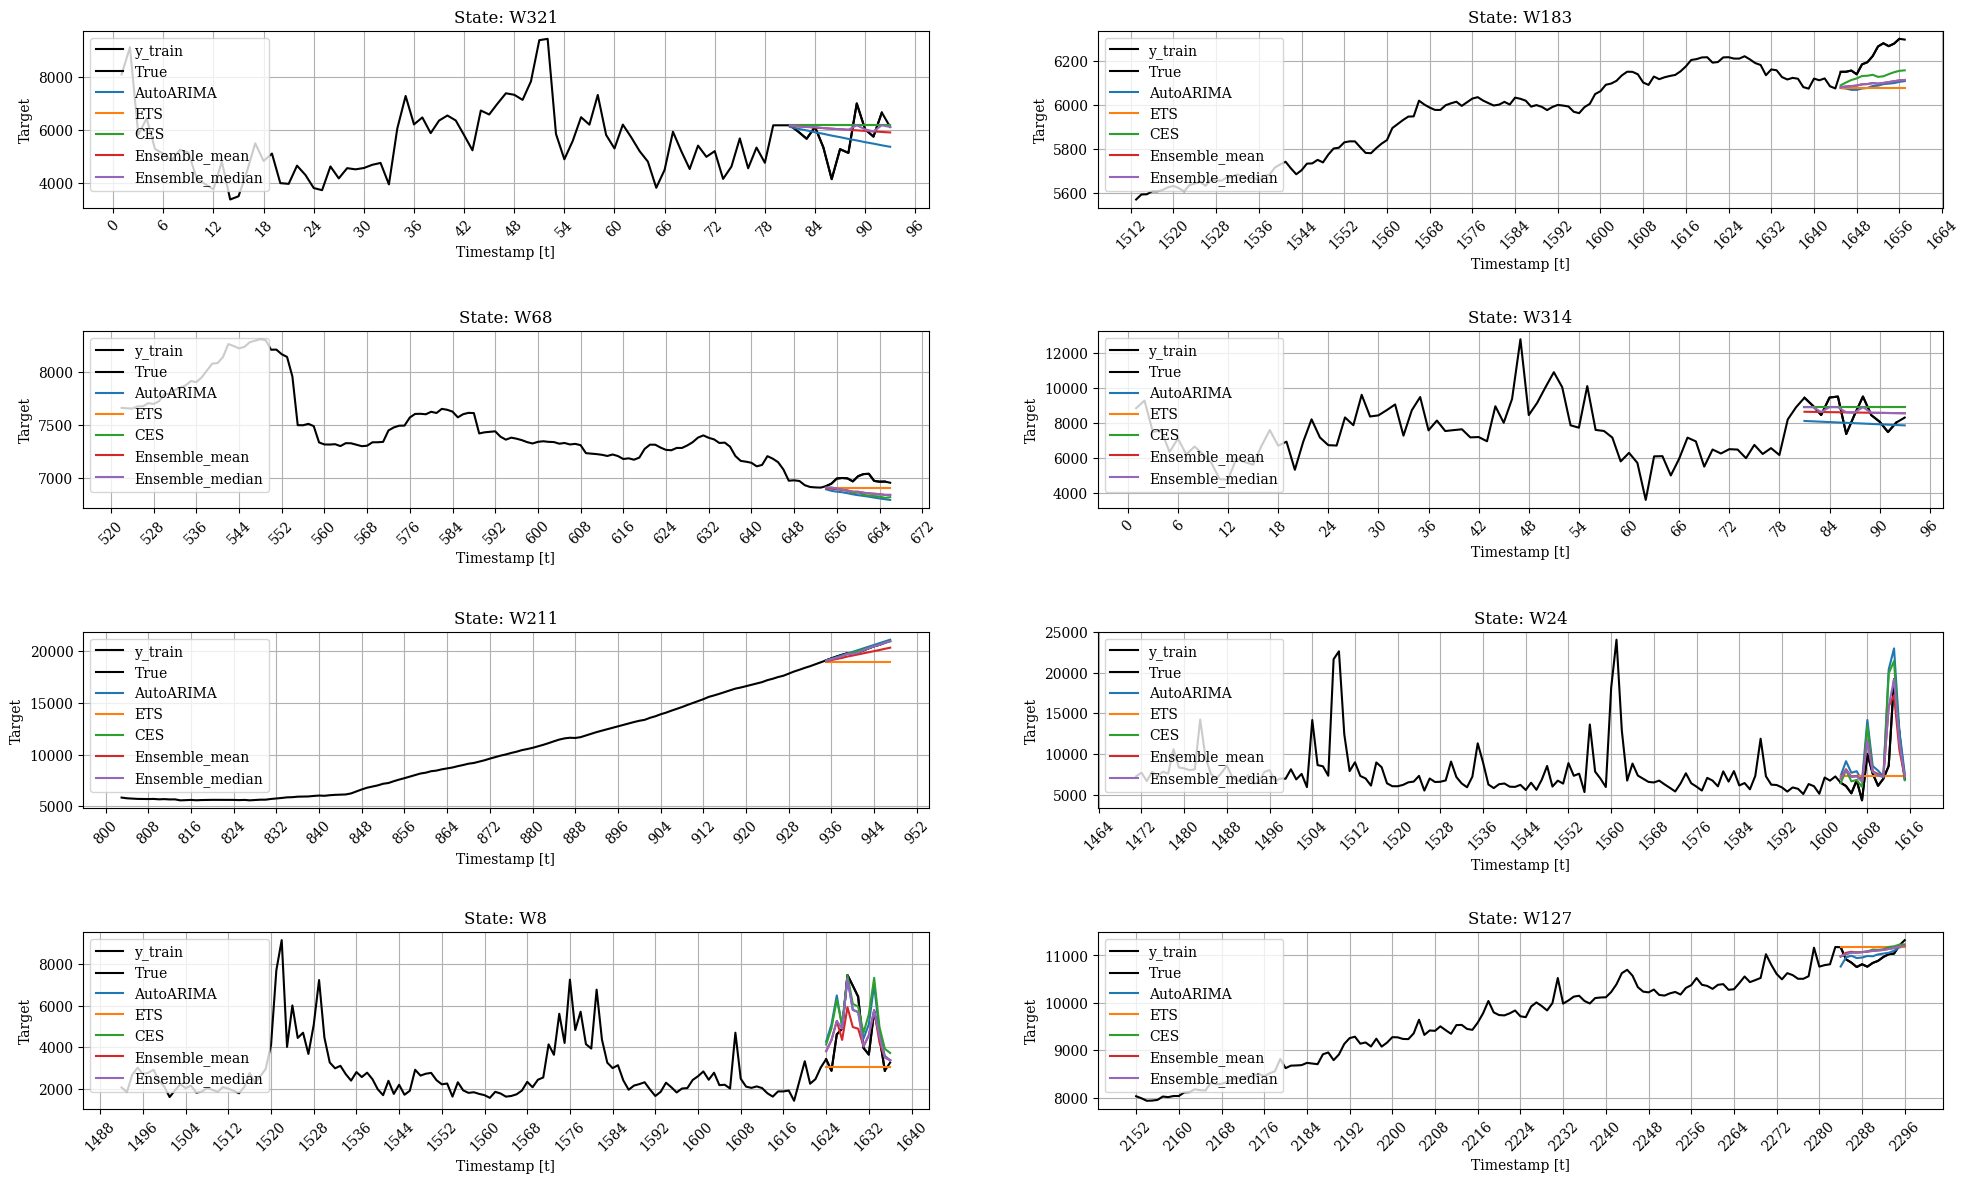

In [242]:
# Get trarin dataframe:
df_train_weekly = get_train_df('Weekly')

# Plot a random sample of 8 series:
plot_grid(df_train_weekly.groupby('unique_id').tail(3*horizon), 
          plot_titles=plot_titles, 
          model_cols=['AutoARIMA', 'ETS', 'CES', 'Ensemble_mean', 'Ensemble_median'], 
          df_test=weekly_df_forecast)

In [172]:
# Measures RMSE, MAE, MAPE and MASE of the models evaluated:
accuracy(weekly_df_forecast, 'Weekly')

,Method,RMSE,MAE,MAPE,MASE
0,AutoARIMA,672.71,326.70,8.04,1.86
1,ETS,673.44,347.99,8.94,1.98
2,CES,620.41,320.38,8.78,1.82
3,Ensemble_mean,526.56,274.23,6.77,1.56
4,Ensemble_median,481.77,235.33,5.89,1.34


### Monthly time series forecast:

In [ ]:
# Create forecasts:
monthly_df_forecast = generate_forecast('data', 'M4', 'Monthly')

In [ ]:
# Create Ensemble models:
monthly_df_forecast['Ensemble_mean'] = (monthly_df_forecast.AutoARIMA + monthly_df_forecast.ETS + monthly_df_forecast.CES) / 3
monthly_df_forecast['Ensemble_median'] = monthly_df_forecast.median(axis=1)

# Export Pandas DataFrame to CSV:
monthly_df_forecast.to_csv('monthly_df_forecast.csv')

# Print dataframe:
monthly_df_forecast

,unique_id,ds,y,AutoARIMA,ETS,CES,Ensemble_mean,Ensemble_median
0,M1,470,8720.0,8951.717773,8408.393555,8511.953125,8624.021484,8624.021484
1,M1,471,7790.0,8672.341797,7553.397461,7647.718262,7957.818848,7790.000000
2,M1,472,4770.0,7298.819336,5874.902344,5973.680176,6382.467285,5973.680176
3,M1,473,5060.0,6906.709961,5539.840332,5628.470215,6025.007324,5628.470215
4,M1,474,4720.0,6446.517578,5032.921875,5007.596191,5495.678223,5032.921875
...,...,...,...,...,...,...,...,...
863995,M9999,83,4200.0,3373.406006,4047.290771,2832.273682,3417.656982,3417.656982
863996,M9999,84,4300.0,3367.464111,3774.587646,2754.740967,3298.930908,3367.464111
863997,M9999,85,3800.0,3353.368896,3109.635742,2272.497070,2911.833984,3109.635742
863998,M9999,86,4400.0,3357.464844,3268.419922,2580.538574,3068.807861,3268.419922


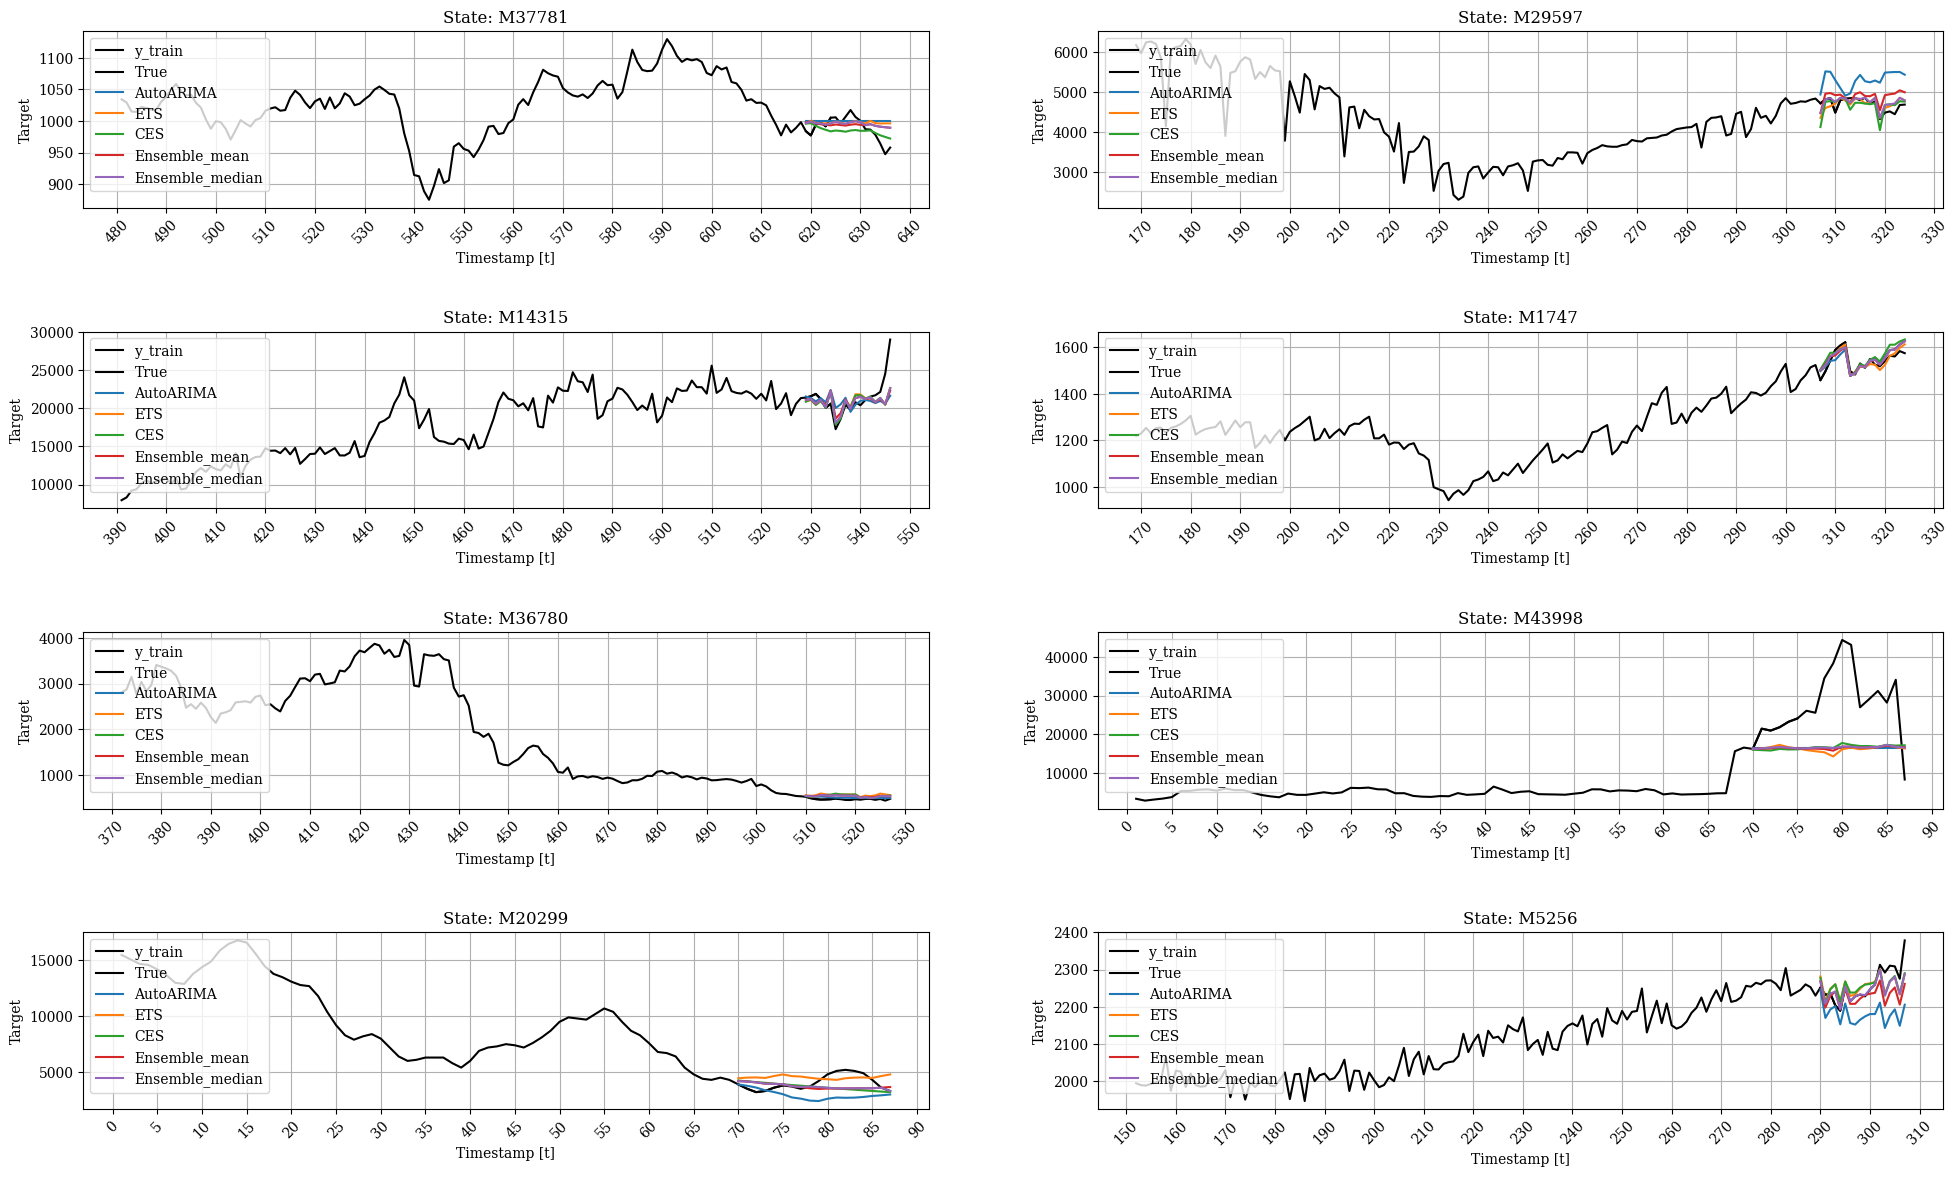

In [244]:
# Get trarin dataframe:
df_train_monthly = get_train_df('Monthly')

# Plot a random sample of 8 series:
plot_grid(df_train_monthly.groupby('unique_id').tail(3*horizon), 
          plot_titles=plot_titles, 
          model_cols=['AutoARIMA', 'ETS', 'CES', 'Ensemble_mean', 'Ensemble_median'], 
          df_test=monthly_df_forecast)

In [173]:
# Measures RMSE, MAE, MAPE and MASE of the models evaluated:
accuracy(monthly_df_forecast, 'Monthly')

,Method,RMSE,MAE,MAPE,MASE
0,AutoARIMA,1609.06,614.02,17.22,0.97
1,ETS,1393.64,568.54,16.04,0.90
2,CES,1533.12,563.16,15.20,0.89
3,Ensemble_mean,1382.43,548.56,15.20,0.87
4,Ensemble_median,1299.33,505.98,13.98,0.80


### Quarterly time series forecast:

In [ ]:
# Create forecasts:
quarterly_df_forecast = generate_forecast('data', 'M4', 'Quarterly')

In [ ]:
# Create Ensemble models:
quarterly_df_forecast['Ensemble_mean'] = (quarterly_df_forecast.AutoARIMA + quarterly_df_forecast.ETS + quarterly_df_forecast.CES) / 3
quarterly_df_forecast['Ensemble_median'] = quarterly_df_forecast.median(axis=1)

# Export Pandas DataFrame to CSV:
quarterly_df_forecast.to_csv('quarterly_df_forecast.csv')

# Print dataframe:
quarterly_df_forecast

,unique_id,ds,y,AutoARIMA,ETS,CES,Ensemble_mean,Ensemble_median
0,Q1,26,6790.643698,6794.014160,6948.307617,6931.533691,6891.285156,6891.285156
1,Q1,27,6598.952202,6837.668457,6779.181641,6738.256348,6785.035156,6779.181641
2,Q1,28,6608.527173,6837.668457,6876.006836,6817.938477,6843.871094,6837.668457
3,Q1,29,6765.914014,6837.668457,6790.493164,6694.187012,6774.116699,6774.116699
4,Q1,30,6992.949003,6837.668457,6948.307617,6843.354492,6876.443848,6876.443848
...,...,...,...,...,...,...,...,...
191995,Q9999,41,10490.000000,10469.712891,10730.284180,10998.307617,10732.768555,10730.284180
191996,Q9999,42,10558.000000,10490.396484,10871.306641,11193.944336,10851.882812,10851.882812
191997,Q9999,43,10832.000000,10506.502930,10987.575195,11406.788086,10966.956055,10966.956055
191998,Q9999,44,11226.000000,10519.044922,11068.744141,11614.723633,11067.503906,11068.744141


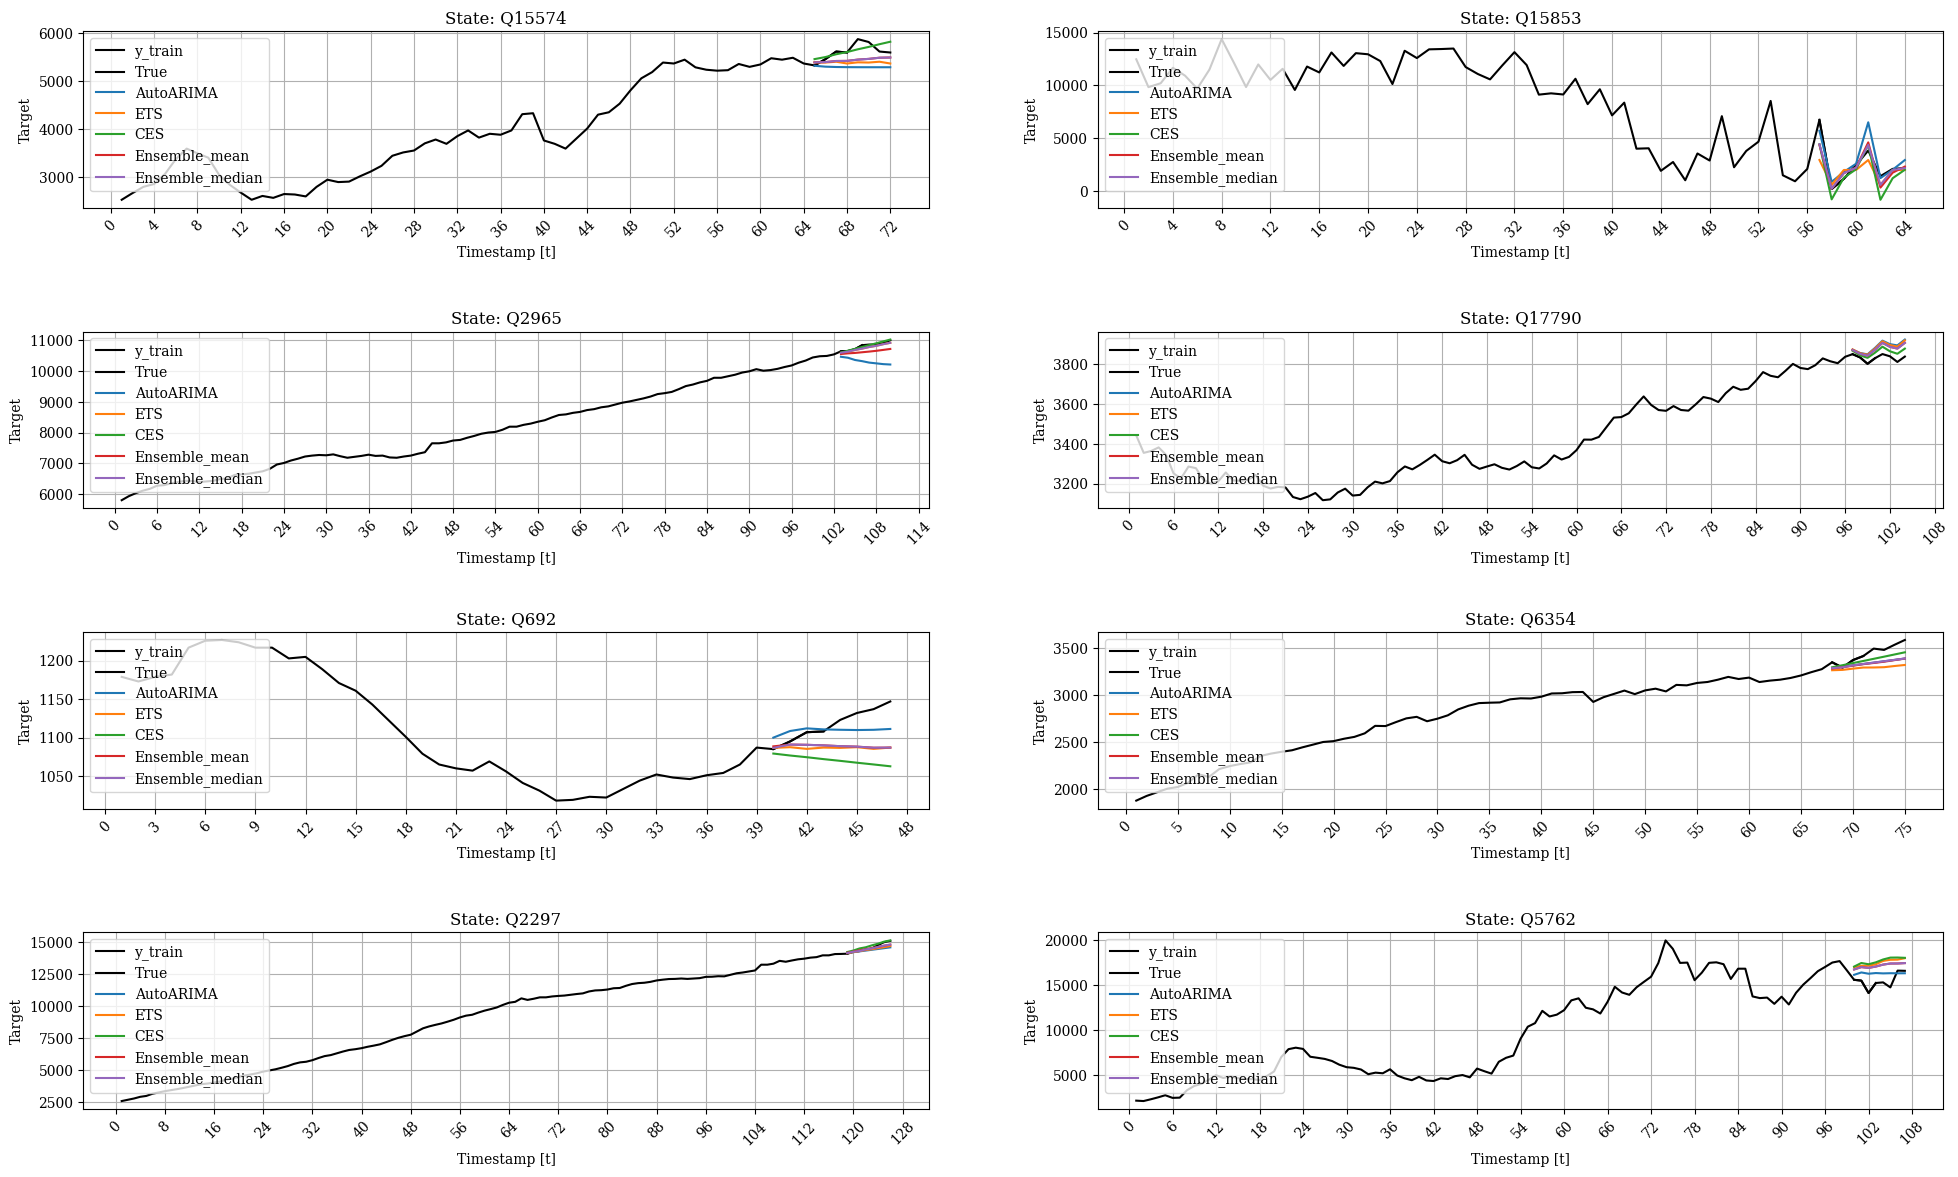

In [245]:
# Get trarin dataframe:
df_train_quarterly = get_train_df('Quarterly')

# Plot a random sample of 8 series:
plot_grid(df_train_quarterly.groupby('unique_id').tail(3*horizon), 
          plot_titles=plot_titles, 
          model_cols=['AutoARIMA', 'ETS', 'CES', 'Ensemble_mean', 'Ensemble_median'], 
          df_test=quarterly_df_forecast)

In [174]:
# Measures RMSE, MAE, MAPE and MASE of the models evaluated:
accuracy(quarterly_df_forecast, 'Quarterly')

,Method,RMSE,MAE,MAPE,MASE
0,AutoARIMA,1549.37,629.85,12.88,1.01
1,ETS,1397.98,571.91,12.39,0.92
2,CES,1452.57,583.58,12.13,0.94
3,Ensemble_mean,1390.69,564.20,11.81,0.90
4,Ensemble_median,1328.98,521.40,10.89,0.84


### Yearly time series forecast:

In [ ]:
# Create forecasts:
yearly_df_forecast = generate_forecast('data', 'M4', 'Yearly')

In [ ]:
# Create Ensemble models:
yearly_df_forecast['Ensemble_mean'] = (yearly_df_forecast.AutoARIMA + yearly_df_forecast.ETS + yearly_df_forecast.CES) / 3
yearly_df_forecast['Ensemble_median'] = yearly_df_forecast.median(axis=1)

# Export Pandas DataFrame to CSV:
yearly_df_forecast.to_csv('yearly_df_forecast.csv')

# Print dataframe:
yearly_df_forecast

,unique_id,ds,y,AutoARIMA,ETS,CES,Ensemble_mean,Ensemble_median
0,Y1,32,7290.2,7094.753418,7261.100098,7410.290039,7255.381348,7261.100098
1,Y1,33,7392.6,6992.039062,7261.100098,7467.259277,7240.132812,7261.100098
2,Y1,34,7527.6,6928.616211,7261.100098,7547.538574,7245.751953,7261.100098
3,Y1,35,7594.8,6889.454102,7261.100098,7610.137207,7253.563965,7261.100098
4,Y1,36,7720.7,6865.272949,7261.100098,7688.244141,7271.539062,7271.539062
...,...,...,...,...,...,...,...,...
137995,Y9999,26,10570.0,10630.656250,9517.000000,10989.168945,10378.941406,10570.000000
137996,Y9999,27,11080.0,11187.484375,9517.000000,11592.649414,10765.710938,11080.000000
137997,Y9999,28,12274.0,11744.312500,9517.000000,12716.774414,11326.028320,11744.312500
137998,Y9999,29,13128.0,12301.140625,9517.000000,13512.682617,11776.941406,12301.140625


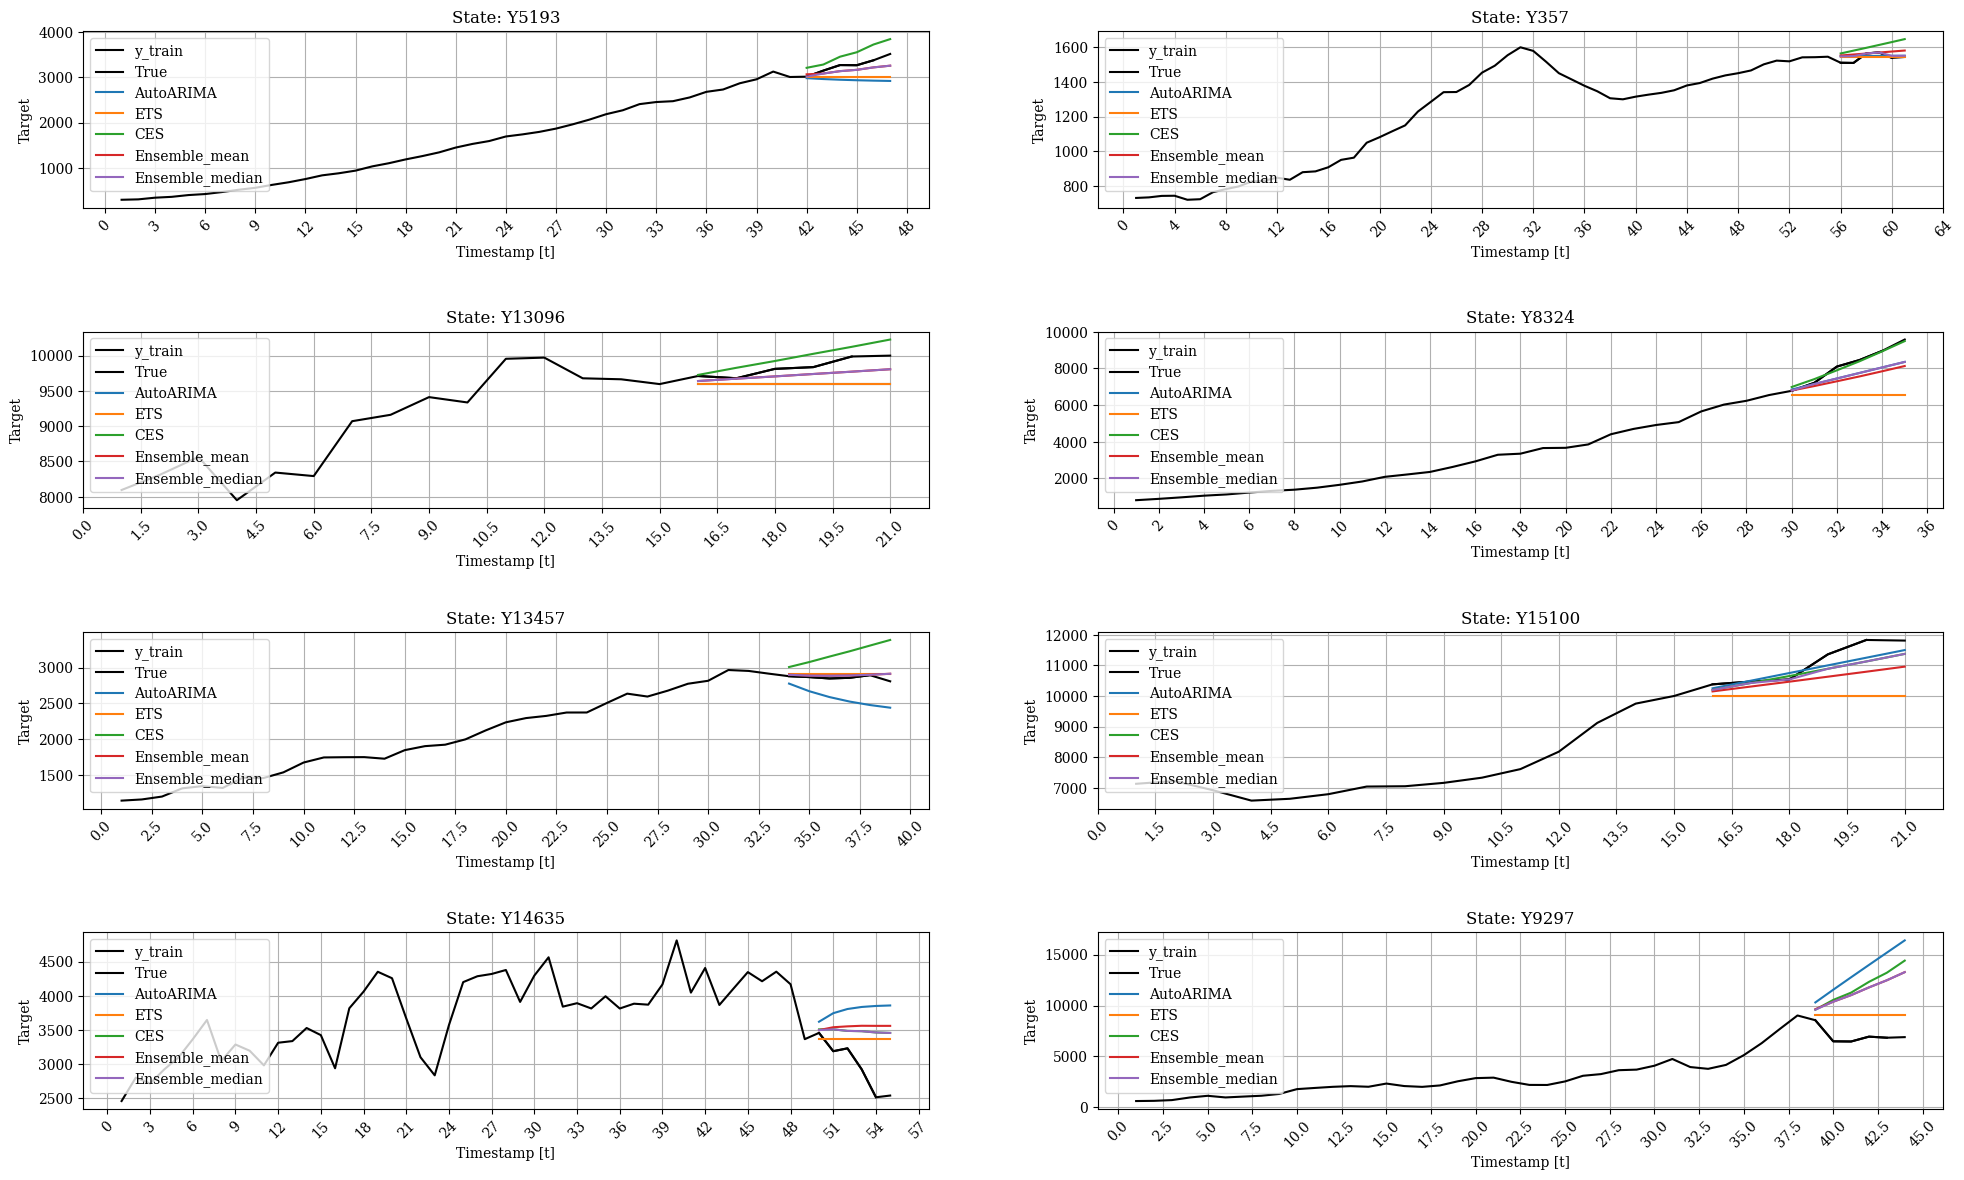

In [248]:
# Get trarin dataframe:
df_train_yearly = get_train_df('Yearly')

# Plot a random sample of 8 series:
plot_grid(df_train_yearly.groupby('unique_id').tail(3*horizon), 
          plot_titles=plot_titles, 
          model_cols=['AutoARIMA', 'ETS', 'CES', 'Ensemble_mean', 'Ensemble_median'], 
          df_test=yearly_df_forecast)

In [175]:
# Measures RMSE, MAE, MAPE and MASE of the models evaluated:
accuracy(yearly_df_forecast, 'Yearly')

,Method,RMSE,MAE,MAPE,MASE
0,AutoARIMA,2141.11,989.85,18.10,2.32
1,ETS,2016.46,1006.92,17.51,2.35
2,CES,2152.40,936.25,17.61,2.19
3,Ensemble_mean,1864.63,842.21,15.87,1.97
4,Ensemble_median,1789.81,770.79,14.59,1.80


### Conclusions

The Ensemble model created in a few lines of code outperform almost all the metrics of AutoARIMA, ETS and CES forecasts by separeted. Studing the metrics of the forecasts genereted for the diferent frequencies it´s intersting to see that the ensemble model created from the median of the 3 basis models outperform the ensemble created from the mean of the same basis models. 

![](Assets/metrics.PNG) 